In [2]:
%cd /home/gabridele/Desktop/irbio_folder/spreading_dynamics_clinical/derivatives
!pwd

/home/gabridele/Desktop/irbio_folder/spreading_dynamics_clinical/derivatives
/home/gabridele/Desktop/irbio_folder/spreading_dynamics_clinical/derivatives


In [3]:
import scipy.stats as stats 
import numpy as np
import pandas as pd
import os, re
import glob
import scikit_posthocs as sp

In [4]:
# extract spearman correlations
def get_spearman_correlation(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        # given second line is spearman corr
        spearman_line = lines[1].strip()
        match = re.search(r"spearman_corr:\s*(-?[\d\.]+)", spearman_line)

        if match:
            return float(match.group(1))
        else:
            print(f"Spearman correlation not found in file {file_path}")

In [5]:
# compute mean correlations divided by groups
def compute_mean_correlations(directory):
    file_pattern = os.path.join(directory, "*.txt")
    files = glob.glob(file_pattern)
    
    groups = {'CTRL': [], 'SCZ': [], 'BPLR': [], 'ADHD': []}

    for file_path in files:
        file_name = os.path.basename(file_path)

        # Skip the mean_spearman_correlations.txt file
        if file_name == "mean_spearman_correlations.txt":
            continue

        correlation = get_spearman_correlation(file_path)

        # Skip if correlation is None
        if correlation is None:
            continue
        
        # Determine the subject group based on the filename
        subject_id = re.search(r"sub-(\d+)_", file_name).group(1)
        
        if subject_id.startswith('1'):
            groups['CTRL'].append(correlation)
        elif subject_id.startswith('5'):
            groups['SCZ'].append(correlation)
        elif subject_id.startswith('6'):
            groups['BPLR'].append(correlation)
        elif subject_id.startswith('7'):
            groups['ADHD'].append(correlation)
    return groups

In [6]:
# directory with text files
directory40 = os.getcwd() + "/output_AFM_40"
directory_rs = os.getcwd() + "/output_AFM_rs"
directory_SC = os.getcwd() + "/output_AFM_SC"

# compute mean correlations
groups_aw = compute_mean_correlations(directory40)
groups_rs = compute_mean_correlations(directory_rs)
groups_sc = compute_mean_correlations(directory_SC)

In [7]:
# calculate median
import statistics
medians = {}

for key in groups_rs:
    medians[key] = statistics.median(groups_rs[key])

print(medians)

{'CTRL': 0.49071110646264426, 'SCZ': 0.37829093561000243, 'BPLR': 0.4175728638721315, 'ADHD': 0.4349313142731469}


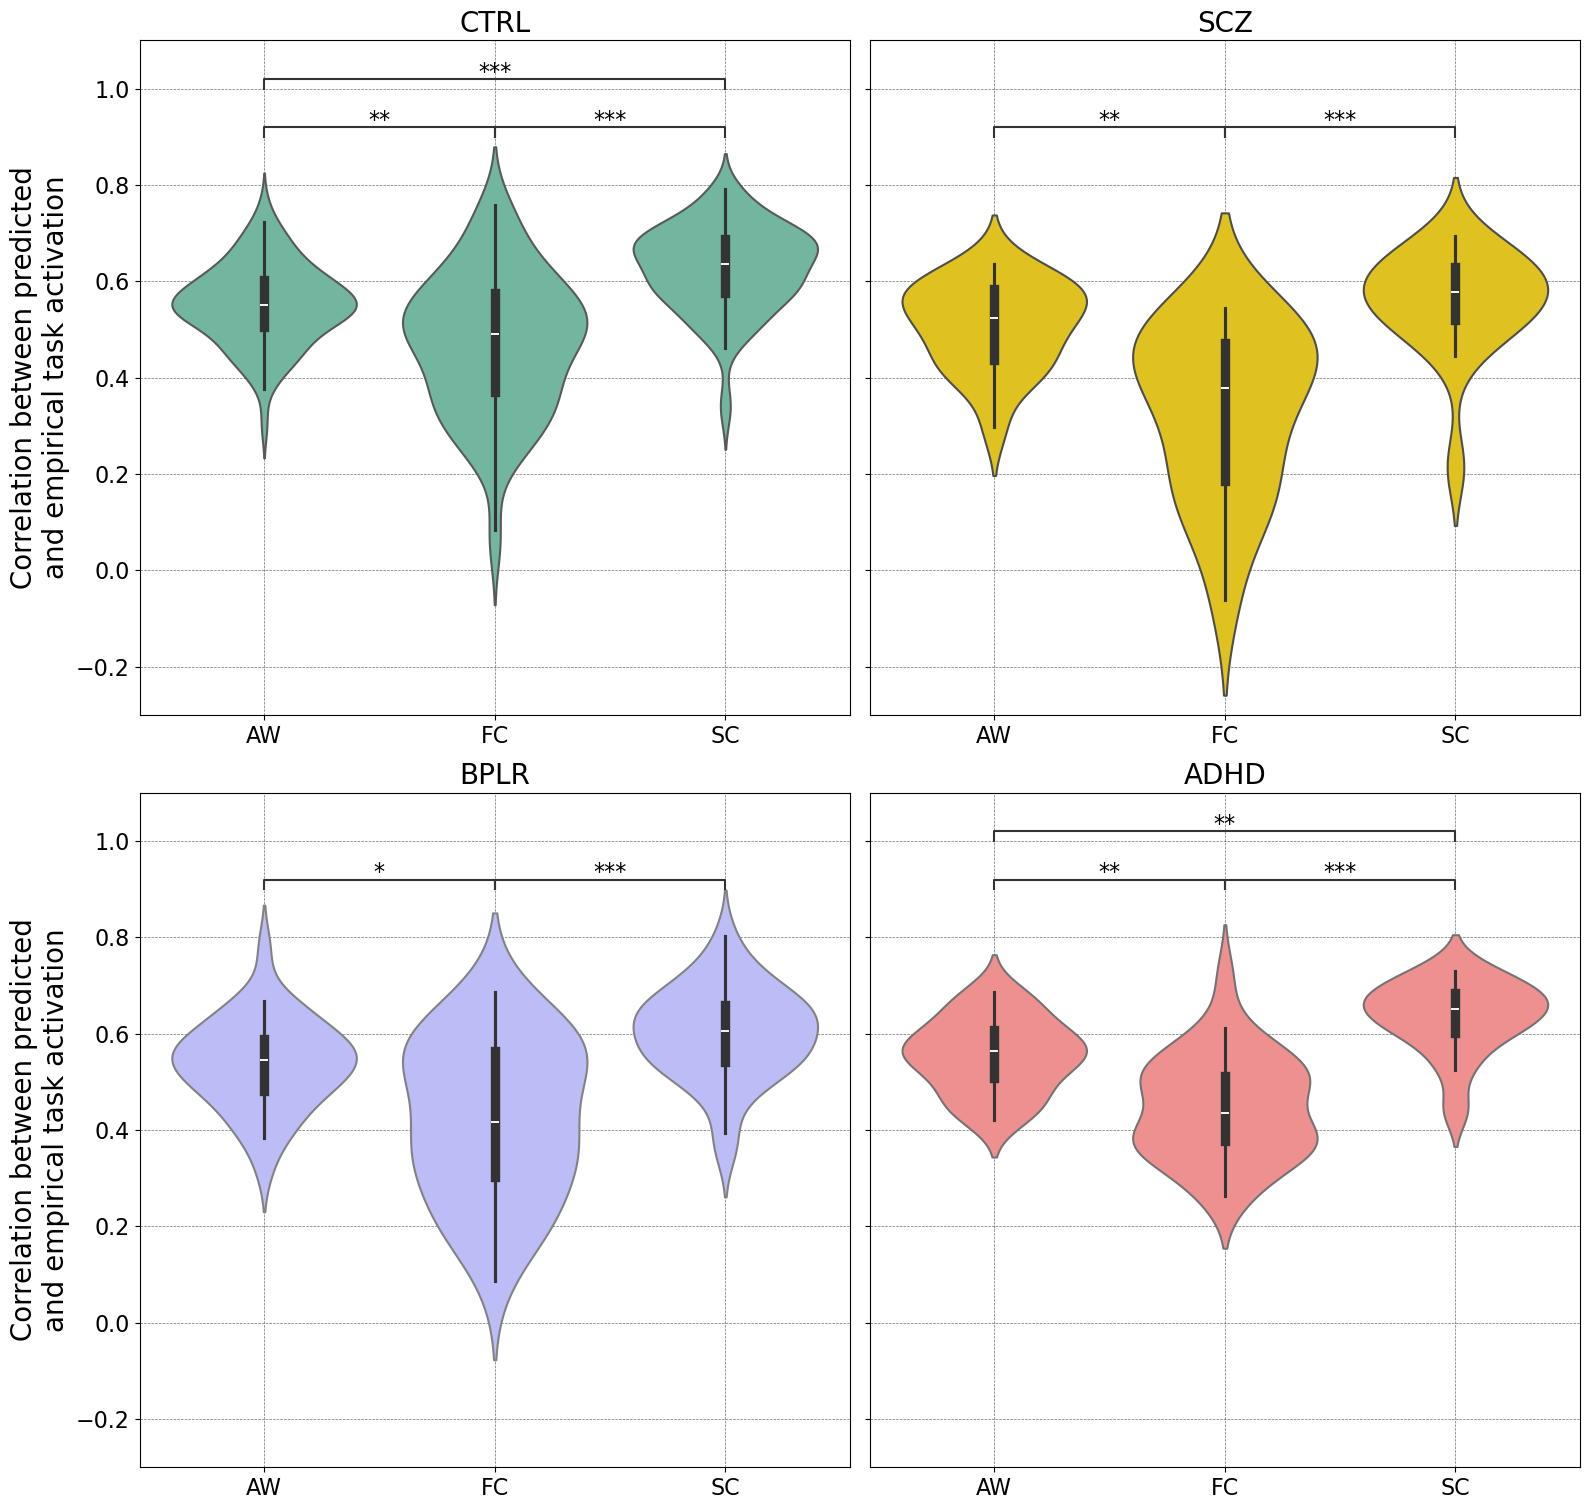

In [14]:
# violin plots showing distribution of correlation across three AFM scenarios
import matplotlib.pyplot as plt
import seaborn as sns
data = {'aw': groups_aw, 'rs': groups_rs, 'sc': groups_sc}

colors = ["#66c2a4", "#ffd700", "#b3b3ff", "#ff8080"]

significant_results = {
    'CTRL': [(0, 1, 0.9, '**'), (1, 2, 0.9, '***'), (0, 2, 1, '***')],
    'SCZ': [(0, 1, 0.9, '**'), (1, 2, 0.9, '***')],
    'BPLR': [(0, 1, 0.9, '*'), (1, 2, 0.9, '***')],
    'ADHD': [(0, 1, 0.9, '**'), (1, 2, 0.9, '***'), (0, 2, 1, '**')]
}

# Create subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(16, 16), sharey=True)
#fig.suptitle('Violin Plots of Correlations by Group', fontsize=22)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plotting
for i, group in enumerate(['CTRL', 'SCZ', 'BPLR', 'ADHD']):
    ax = axes[i]
    
    # Use a single color for all violins in the same subplot
    sns.violinplot(data=[data['aw'][group], data['rs'][group], data['sc'][group]], 
               palette=[colors[i]]*3, ax=ax, inner='box', linewidth=1.5)
    
    ax.set_title(group.upper())
    ax.set_xticks([0, 1, 2])
    ax.set_title(group.upper(), fontsize=20)  # Increase title size
    ax.set_ylabel('Correlation', fontsize=16)  # Increase y-axis label size
    ax.set_xticklabels(['AW', 'FC', 'SC'], fontsize=15)  # Increase x-axis label size
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xticklabels(['AW', 'FC', 'SC'])
    ax.set_ylabel(' Correlation between predicted \nand empirical task activation', fontsize=20)
    ax.set_ylim([-0.3, 1.1])
    # Add a light grid in the background
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    ax.set_axisbelow(True)

    if group in significant_results:
        for (x_start, x_end, y, significance) in significant_results[group]:
            # Draw the bar
            ax.plot([x_start, x_start, x_end, x_end], [y, y+0.02, y+0.02, y], lw=1.5, color='black')
            # Add the significance text (e.g., ** or *)
            ax.text((x_start + x_end) * 0.5, y + 0.01, significance, ha='center', va='bottom', color='black', fontsize=16)


    for art in ax.findobj(match=plt.Line2D):
        art.set_color("#333333")
# Adjust layout to prevent overlap and improve spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [64]:
# performing non parametric version of anova, kruskal-wallis
data = {'aw': groups_aw, 'rs': groups_rs, 'sc': groups_sc}
for i, group in enumerate(['CTRL', 'SCZ', 'BPLR', 'ADHD']):
    a = stats.kruskal(data['aw'][group], data['rs'][group], data['sc'][group])
    print(a)
    

KruskalResult(statistic=65.0466555528667, pvalue=7.504093101005239e-15)
KruskalResult(statistic=21.65791245791246, pvalue=1.981728088464036e-05)
KruskalResult(statistic=23.233244868478494, pvalue=9.014984377647309e-06)
KruskalResult(statistic=40.85890109890113, pvalue=1.3415360822906521e-09)


In [65]:
df = pd.DataFrame(data).T

In [66]:
df

,CTRL,SCZ,BPLR,ADHD
aw,"[0.6320512232756593, 0.3762982789099014, 0.546...","[0.57733231555328, 0.5852651443138919, 0.49245...","[0.5193396270269973, 0.5612105798129297, 0.510...","[0.6121983568259496, 0.6101925906167817, 0.514..."
rs,"[0.24487575326575448, 0.5337823344728139, 0.29...","[0.41266918162212374, 0.46302043140979754, 0.1...","[0.5514978005627711, 0.6767940056559246, 0.608...","[0.38541233950059656, 0.5051896203105467, 0.38..."
sc,"[0.5261429462879338, 0.6762907143028648, 0.617...","[0.6182623039107986, 0.4827026228140677, 0.594...","[0.5265468042048422, 0.6655571049087071, 0.695...","[0.676960073505862, 0.6758259944166488, 0.6587..."


In [67]:
# divide dataset into subgroups
df_CTRL = df[['CTRL']].T
df_SCZ = df[['SCZ']].T
df_BPLR = df[['BPLR']].T
df_ADHD = df[['ADHD']].T

In [68]:
# Explode the lists into individual rows
df_CTRL = df_CTRL.apply(pd.Series.explode)

# Reshape the DataFrame into long format: create two columns, one for values and one for groups
df_CTRL = df_CTRL.melt(var_name='group', value_name='value')

# Explode the lists into individual rows
df_SCZ = df_SCZ.apply(pd.Series.explode)

# Reshape the DataFrame into long format: create two columns, one for values and one for groups
df_SCZ = df_SCZ.melt(var_name='group', value_name='value')

# Explode the lists into individual rows
df_BPLR = df_BPLR.apply(pd.Series.explode)

# Reshape the DataFrame into long format: create two columns, one for values and one for groups
df_BPLR = df_BPLR.melt(var_name='group', value_name='value')

# Explode the lists into individual rows
df_ADHD = df_ADHD.apply(pd.Series.explode)

# Reshape the DataFrame into long format: create two columns, one for values and one for groups
df_ADHD = df_ADHD.melt(var_name='group', value_name='value')

In [19]:
# perform Dunn's test for post hoc analysis
dunn_CTRL = sp.posthoc_dunn(df_CTRL, val_col='value', group_col='group', p_adjust='bonferroni')
dunn_SCZ = sp.posthoc_dunn(df_SCZ, val_col='value', group_col='group', p_adjust='bonferroni')
dunn_BPLR = sp.posthoc_dunn(df_BPLR, val_col='value', group_col='group', p_adjust='bonferroni')
dunn_ADHD = sp.posthoc_dunn(df_ADHD, val_col='value', group_col='group', p_adjust='bonferroni')

In [20]:
dunn_CTRL

,aw,rs,sc
aw,1.000000,3.207004e-03,6.155149e-06
rs,0.003207,1.000000e+00,3.173132e-15
sc,0.000006,3.173132e-15,1.000000e+00


In [21]:
dunn_SCZ

,aw,rs,sc
aw,1.000000,0.007601,0.358182
rs,0.007601,1.000000,0.000014
sc,0.358182,0.000014,1.000000


In [22]:
dunn_BPLR

,aw,rs,sc
aw,1.000000,0.041791,0.054722
rs,0.041791,1.000000,0.000004
sc,0.054722,0.000004,1.000000


In [35]:
dunn_ADHD

,aw,rs,sc
aw,1.000000,2.420438e-03,7.118058e-03
rs,0.002420,1.000000e+00,4.990615e-10
sc,0.007118,4.990615e-10,1.000000e+00
